In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from scipy.stats import spearmanr
from statsmodels.graphics.tsaplots import plot_acf
import itertools
from itertools import product
import warnings
warnings.filterwarnings('ignore')  # 关闭所有警告

plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为 SimHei
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

In [2]:
# 读取 Excel 文件
file_path = 'data.xlsx'

# 查看文件内所有sheet名，确认需要读取的sheet
xls = pd.ExcelFile(file_path)
print("Sheet names:", xls.sheet_names)

Sheet names: ['收盘价', '自由流通换手率']


In [3]:
# 读取 sheet1
df = pd.read_excel(file_path, sheet_name='收盘价')

In [4]:
# 将第一列（日期列）重命名为 'date'
df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

# 将 'date' 转换为 datetime 格式
df['date'] = pd.to_datetime(df['date'])

# 设置为 index
df = df.set_index('date')

# 检查结果
print(df.head())
print(df.index)

               50收益  中证1000全收益     800收益
date                                    
2005-01-04  835.130    989.984  983.8953
2005-01-05  839.529   1013.583  995.5764
2005-01-06  830.513   1005.466  986.2162
2005-01-07  831.641   1011.740  987.6929
2005-01-10  841.102   1023.638  997.1864
DatetimeIndex(['2005-01-04', '2005-01-05', '2005-01-06', '2005-01-07',
               '2005-01-10', '2005-01-11', '2005-01-12', '2005-01-13',
               '2005-01-14', '2005-01-17',
               ...
               '2025-06-16', '2025-06-17', '2025-06-18', '2025-06-19',
               '2025-06-20', '2025-06-23', '2025-06-24', '2025-06-25',
               '2025-06-26', '2025-06-27'],
              dtype='datetime64[ns]', name='date', length=4974, freq=None)


超额净值曲线

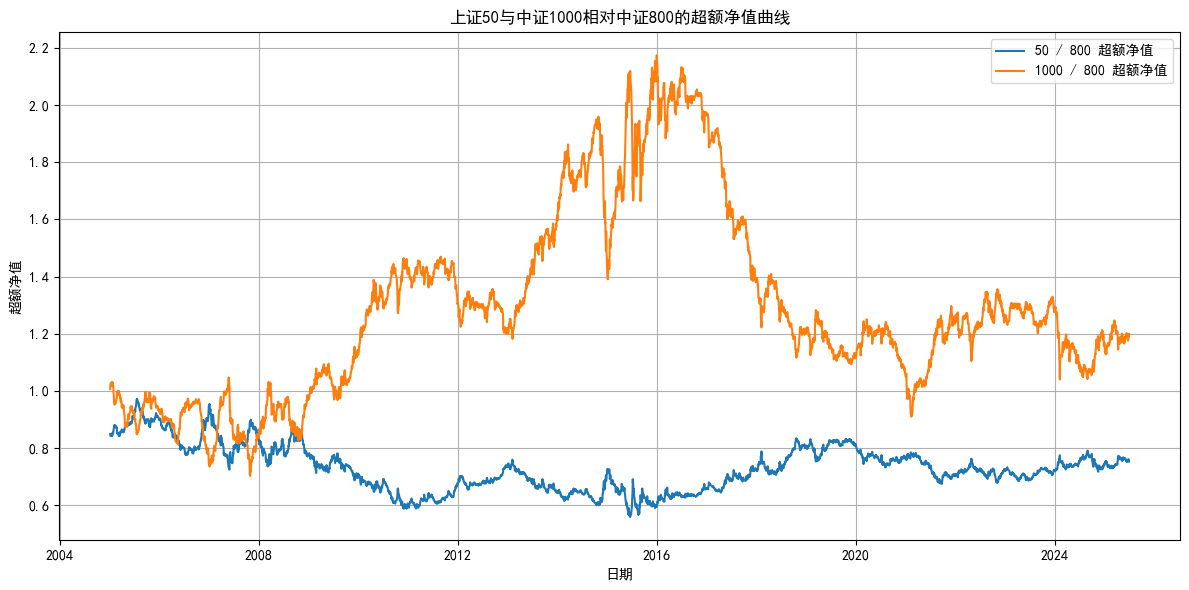

In [5]:
# 计算超额净值曲线
df['50_over_800'] = df['50收益'] / df['800收益']
df['1000_over_800'] = df['中证1000全收益'] / df['800收益']

# 画图
plt.figure(figsize=(12,6))
plt.plot(df.index, df['50_over_800'], label='50 / 800 超额净值')
plt.plot(df.index, df['1000_over_800'], label='1000 / 800 超额净值')

# 图表美化
plt.title('上证50与中证1000相对中证800的超额净值曲线')
plt.xlabel('日期')
plt.ylabel('超额净值')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

收益率分布

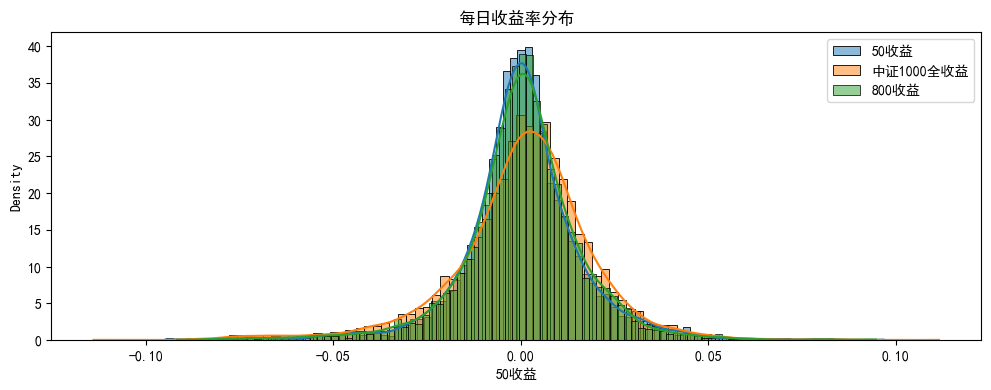

偏度 (skewness)：
50收益        -0.121021
中证1000全收益   -0.661163
800收益       -0.424345
dtype: float64

峰度 (kurtosis)：
50收益         4.532855
中证1000全收益    3.295284
800收益        4.328902
dtype: float64


In [6]:
# 计算每日简单收益率
returns = df[['50收益', '中证1000全收益', '800收益']].pct_change().dropna()

# 画出直方图
plt.figure(figsize=(12,4))
for col in returns.columns:
    sns.histplot(returns[col], bins=100, kde=True, label=col, stat='density')
plt.title('每日收益率分布')
plt.legend()
plt.show()

# 查看偏度与峰度
print('偏度 (skewness)：')
print(returns.skew())
print('\n峰度 (kurtosis)：')
print(returns.kurt())

收益率时间序列图

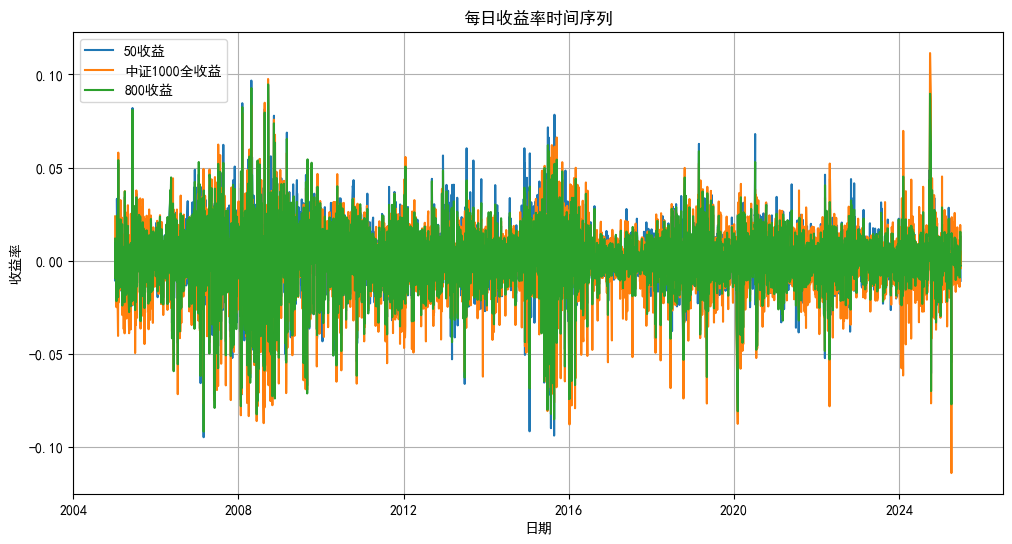

In [7]:
plt.figure(figsize=(12,6))
for col in returns.columns:
    plt.plot(returns.index, returns[col], label=col)
plt.title('每日收益率时间序列')
plt.xlabel('日期')
plt.ylabel('收益率')
plt.legend()
plt.grid(True)
plt.show()


波动率分析

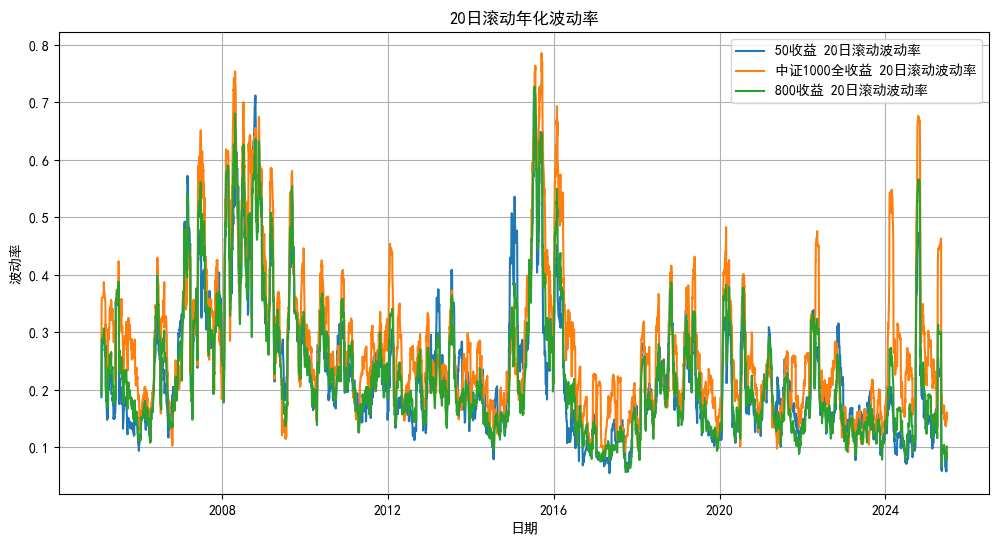

In [8]:
window = 20  # 例如计算20日滚动波动率

volatility = returns.rolling(window).std() * np.sqrt(252)  # annualized

plt.figure(figsize=(12,6))
for col in volatility.columns:
    plt.plot(volatility.index, volatility[col], label=f'{col} {window}日滚动波动率')
plt.title(f'{window}日滚动年化波动率')
plt.xlabel('日期')
plt.ylabel('波动率')
plt.legend()
plt.grid(True)
plt.show()


相关性矩阵

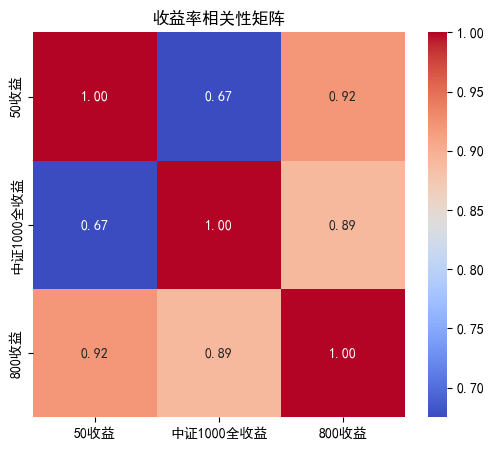

In [9]:
corr = returns.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('收益率相关性矩阵')
plt.show()

移动均线

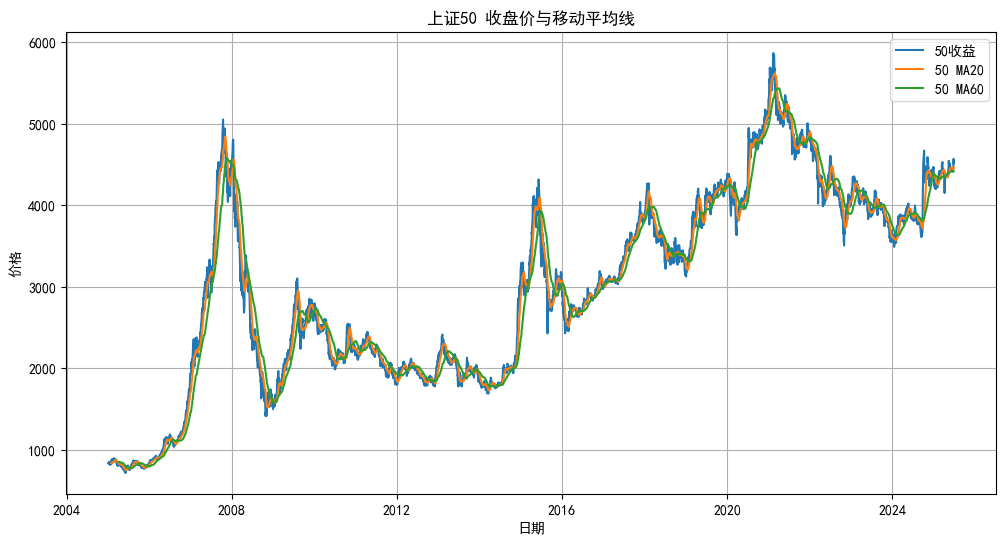

In [10]:
plt.figure(figsize=(12,6))
df['50_MA20'] = df['50收益'].rolling(20).mean()
df['50_MA60'] = df['50收益'].rolling(60).mean()
plt.plot(df.index, df['50收益'], label='50收益')
plt.plot(df.index, df['50_MA20'], label='50 MA20')
plt.plot(df.index, df['50_MA60'], label='50 MA60')
plt.title('上证50 收盘价与移动平均线')
plt.xlabel('日期')
plt.ylabel('价格')
plt.legend()
plt.grid(True)
plt.show()


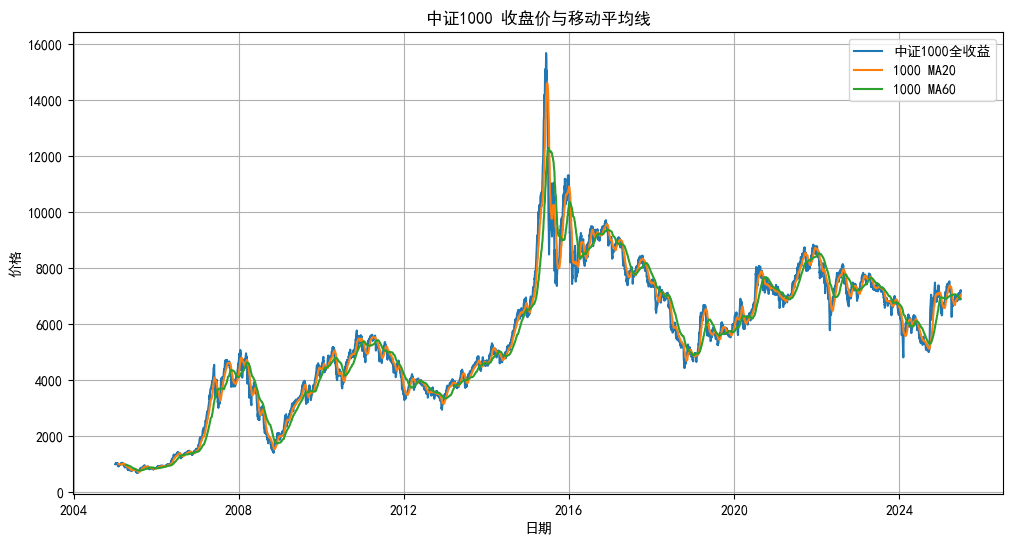

In [11]:
plt.figure(figsize=(12,6))
df['1000_MA20'] = df['中证1000全收益'].rolling(20).mean()
df['1000_MA60'] = df['中证1000全收益'].rolling(60).mean()
plt.plot(df.index, df['中证1000全收益'], label='中证1000全收益')
plt.plot(df.index, df['1000_MA20'], label='1000 MA20')
plt.plot(df.index, df['1000_MA60'], label='1000 MA60')
plt.title('中证1000 收盘价与移动平均线')
plt.xlabel('日期')
plt.ylabel('价格')
plt.legend()
plt.grid(True)
plt.show()


RSI指标

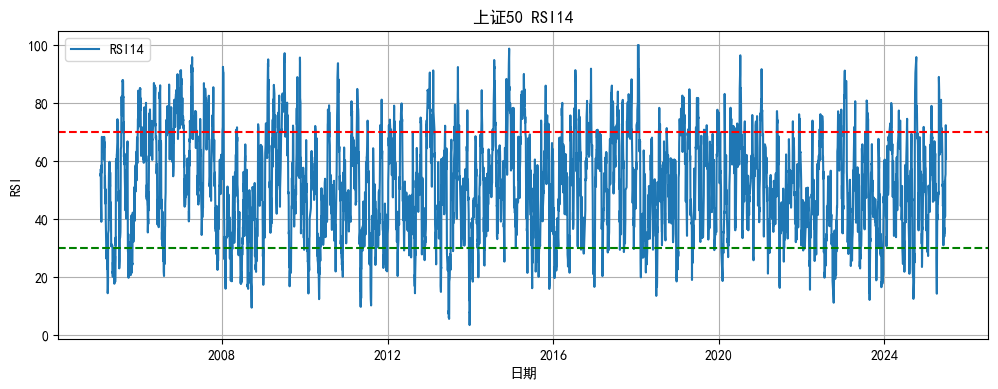

In [12]:
def compute_rsi(series, period=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.rolling(period).mean()
    ma_down = down.rolling(period).mean()
    rsi = 100 - (100 / (1 + ma_up / ma_down))
    return rsi

df['50_RSI14'] = compute_rsi(df['50收益'])

plt.figure(figsize=(12,4))
plt.plot(df.index, df['50_RSI14'], label='RSI14')
plt.title('上证50 RSI14')
plt.axhline(70, color='r', linestyle='--')
plt.axhline(30, color='g', linestyle='--')
plt.xlabel('日期')
plt.ylabel('RSI')
plt.legend()
plt.grid(True)
plt.show()


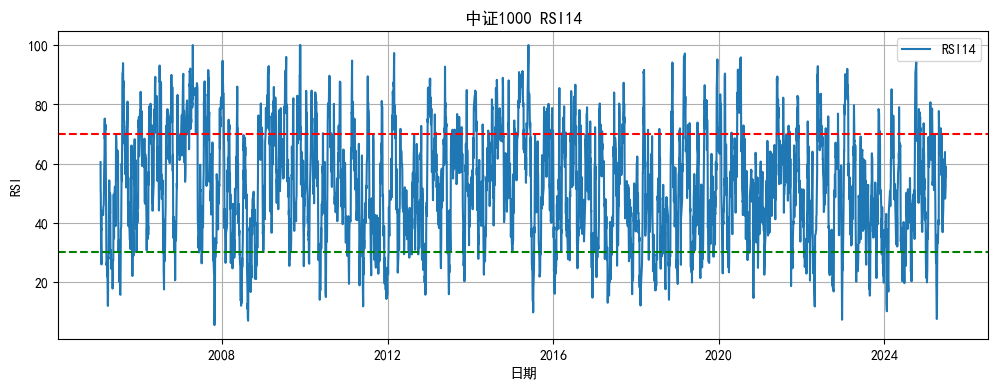

In [13]:
def compute_rsi(series, period=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.rolling(period).mean()
    ma_down = down.rolling(period).mean()
    rsi = 100 - (100 / (1 + ma_up / ma_down))
    return rsi

df['1000_RSI14'] = compute_rsi(df['中证1000全收益'])

plt.figure(figsize=(12,4))
plt.plot(df.index, df['1000_RSI14'], label='RSI14')
plt.title('中证1000 RSI14')
plt.axhline(70, color='r', linestyle='--')
plt.axhline(30, color='g', linestyle='--')
plt.xlabel('日期')
plt.ylabel('RSI')
plt.legend()
plt.grid(True)
plt.show()

最大回撤分析

In [14]:
def max_drawdown(series):
    roll_max = series.cummax()
    daily_drawdown = series / roll_max - 1
    max_dd = daily_drawdown.min()
    return max_dd

print('最大回撤：')
for col in df[['50收益', '中证1000全收益', '800收益']].columns:
    mdd = max_drawdown(df[col])
    print(f"{col}: {mdd:.2%}")


最大回撤：
50收益: -72.07%
中证1000全收益: -72.47%
800收益: -71.51%


### 动量趋势+波动率加权

In [15]:
def momentum_volatility_strategy(df, window=20, threshold=0.01, min_large_weight=0.7):
    """
    大小盘切换策略：动量趋势 + 波动率加权

    参数:
    - df: DataFrame，包含 '50收益' 和 '中证1000全收益' 两列
    - window: int，计算动量与波动率的窗口期
    - threshold: float，小盘相对大盘收益率超过阈值才切换
    - min_large_weight: float，不满足动量条件时，大盘的最小配置比例

    返回:
    - position_df: DataFrame，包含 'position_50' 和 'position_1000' 两列，二者加总为1
    """

    # 计算20日收益率
    r_50 = df['50收益'].pct_change(periods=window)
    r_1000 = df['中证1000全收益'].pct_change(periods=window)

    # 计算20日波动率
    vol_50 = df['50收益'].pct_change().rolling(window).std()
    vol_1000 = df['中证1000全收益'].pct_change().rolling(window).std()

    # 避免除零错误，加入epsilon
    epsilon = 1e-8
    inv_vol_50 = 1 / (vol_50 + epsilon)
    inv_vol_1000 = 1 / (vol_1000 + epsilon)
    total_inv_vol = inv_vol_50 + inv_vol_1000

    # 计算波动率加权仓位
    weight_50 = inv_vol_50 / total_inv_vol
    weight_1000 = inv_vol_1000 / total_inv_vol

    # 计算动量条件
    momentum_condition = r_1000 > r_50 + threshold

    # 根据动量条件决定仓位配置
    position_50 = np.where(momentum_condition, weight_50, min_large_weight)
    position_1000 = np.where(momentum_condition, weight_1000, 1 - min_large_weight)

    # 确保二者加总为1（数值稳定性）
    position_sum = position_50 + position_1000
    position_50 /= position_sum
    position_1000 /= position_sum

    # 输出DataFrame
    position_df = pd.DataFrame({
        'position_50': position_50,
        'position_1000': position_1000
    }, index=df.index)

    return position_df

In [16]:
def momentum_volatility_strategy_monthly(df, window=20, threshold=0.01, min_large_weight=0.7):
    """
    大小盘切换策略（月度调仓版本）：动量趋势 + 波动率加权

    参数:
    - df: DataFrame，包含 '50收益' 和 '中证1000全收益' 两列
    - window: int，计算动量与波动率的窗口期
    - threshold: float，小盘相对大盘收益率超过阈值才切换
    - min_large_weight: float，不满足动量条件时，大盘的最小配置比例

    返回:
    - position_df: DataFrame，包含 'position_50' 和 'position_1000' 两列，二者加总为1
    """

    # 计算动量
    r_50 = df['50收益'].pct_change(periods=window)
    r_1000 = df['中证1000全收益'].pct_change(periods=window)

    # 计算波动率
    vol_50 = df['50收益'].pct_change().rolling(window).std()
    vol_1000 = df['中证1000全收益'].pct_change().rolling(window).std()

    epsilon = 1e-8
    inv_vol_50 = 1 / (vol_50 + epsilon)
    inv_vol_1000 = 1 / (vol_1000 + epsilon)
    total_inv_vol = inv_vol_50 + inv_vol_1000

    weight_50 = inv_vol_50 / total_inv_vol
    weight_1000 = inv_vol_1000 / total_inv_vol

    # 提取每月最后一个交易日
    month_end_dates = df.resample('M').last().index

    # 初始化仓位Series
    position_50 = pd.Series(index=df.index, dtype='float64')
    position_1000 = pd.Series(index=df.index, dtype='float64')

    # 初始化当前仓位
    current_pos_50 = min_large_weight
    current_pos_1000 = 1 - min_large_weight

    for date in df.index:
        if date in month_end_dates:
            # 计算当月信号
            if (r_1000.loc[date] > r_50.loc[date] + threshold):
                if not np.isnan(weight_50.loc[date]) and not np.isnan(weight_1000.loc[date]):
                    current_pos_50 = weight_50.loc[date]
                    current_pos_1000 = weight_1000.loc[date]
            else:
                current_pos_50 = min_large_weight
                current_pos_1000 = 1 - min_large_weight

            # 数值稳定性：归一化
            total = current_pos_50 + current_pos_1000
            current_pos_50 /= total
            current_pos_1000 /= total

        # 记录当日仓位
        position_50.loc[date] = current_pos_50
        position_1000.loc[date] = current_pos_1000

    # 输出DataFrame
    position_df = pd.DataFrame({
        'position_50': position_50,
        'position_1000': position_1000
    }, index=df.index)

    return position_df


In [17]:
# 获取策略每日仓位
position_df = momentum_volatility_strategy_monthly(df)

# =============================
# 计算每日组合收益率
# =============================
returns_50 = df['50收益'].pct_change()
returns_1000 = df['中证1000全收益'].pct_change()
portfolio_returns = position_df['position_50'] * returns_50 + position_df['position_1000'] * returns_1000
portfolio_returns = portfolio_returns.fillna(0)

# =============================
# 计算净值与超额净值曲线
# =============================
portfolio_nav = (1 + portfolio_returns).cumprod()
benchmark_nav = df['800收益'] / df['800收益'].iloc[0]
excess_nav = portfolio_nav / benchmark_nav

# =============================
# 计算回测指标
# =============================
annual_return = portfolio_nav.iloc[-1] ** (252 / len(portfolio_nav)) - 1
annual_vol = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = annual_return / annual_vol
max_drawdown = (portfolio_nav / portfolio_nav.cummax() - 1).min()
calmar_ratio = annual_return / abs(max_drawdown)

# =============================
# 输出结果
# =============================
print(f"【回测指标】")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")


【回测指标】
年化收益率: 11.22%
年化波动率: 25.14%
夏普比率: 0.45
最大回撤: -70.57%
Calmar Ratio: 0.16


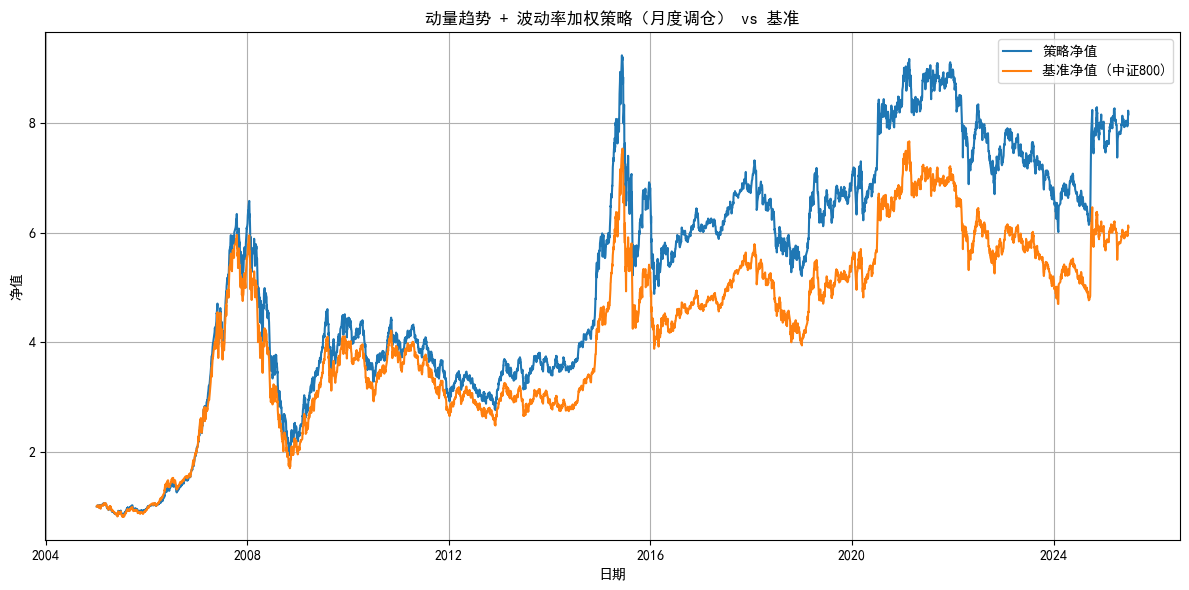

In [18]:
# 绘制净值曲线
plt.figure(figsize=(12,6))
plt.plot(portfolio_nav, label='策略净值')
plt.plot(benchmark_nav, label='基准净值 (中证800)')
plt.title('动量趋势 + 波动率加权策略（月度调仓） vs 基准')
plt.xlabel('日期')
plt.ylabel('净值')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

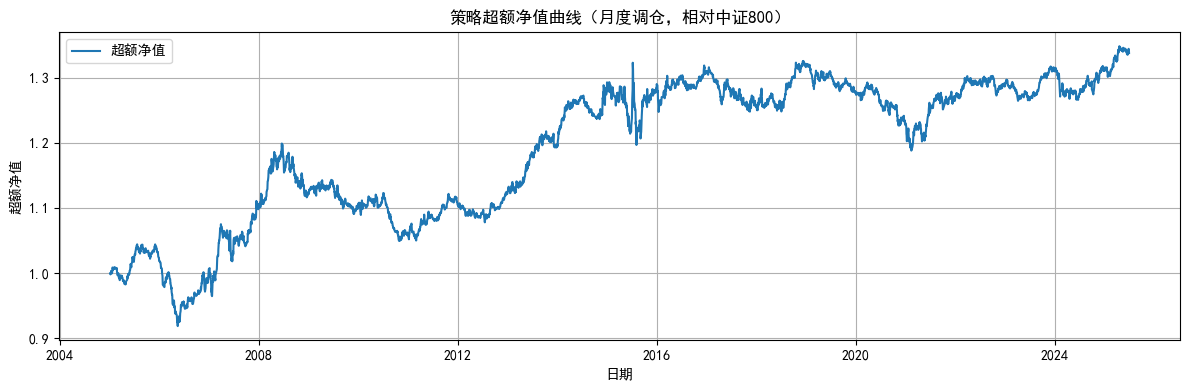

In [19]:
# 绘制超额净值曲线
plt.figure(figsize=(12,4))
plt.plot(excess_nav, label='超额净值')
plt.title('策略超额净值曲线（月度调仓，相对中证800）')
plt.xlabel('日期')
plt.ylabel('超额净值')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

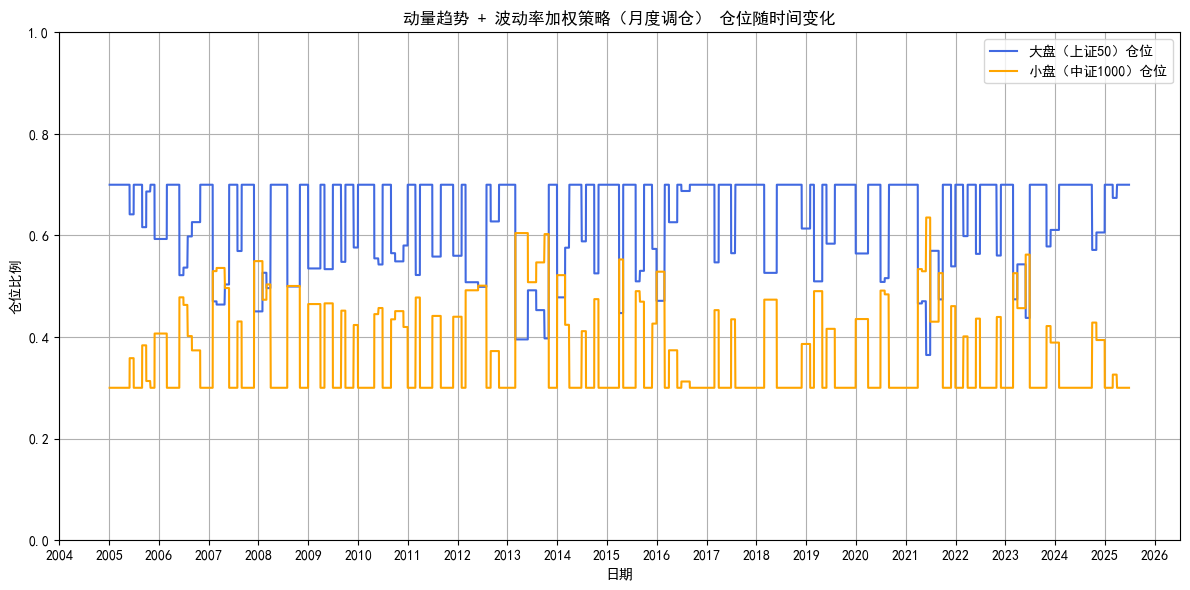

In [20]:
# 绘制仓位随时间变化图
plt.figure(figsize=(12,6))
plt.plot(position_df.index, position_df['position_50'], label='大盘（上证50）仓位', color='royalblue')
plt.plot(position_df.index, position_df['position_1000'], label='小盘（中证1000）仓位', color='orange')

plt.title('动量趋势 + 波动率加权策略（月度调仓） 仓位随时间变化')
plt.xlabel('日期')
plt.ylabel('仓位比例')
plt.ylim(0,1)  # 仓位比例限制在0-1之间
plt.legend()
plt.grid(True)

# 如果x轴过于密集，可使用以下代码仅显示每年刻度
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

参数调优

In [21]:
window_range = [10, 20, 30, 40, 50, 60]
threshold_range = [0.0, 0.005, 0.01, 0.015, 0.02]
min_large_weight_range = [0.5, 0.6, 0.7, 0.8, 0.9]

# =============================
# 记录结果
# =============================
results = []

# =============================
# Grid Search
# =============================
for window, threshold, min_large_weight in itertools.product(window_range, threshold_range, min_large_weight_range):
    
    # 获取策略仓位（调用月度调仓版本）
    position_df = momentum_volatility_strategy_monthly(df, window=window, threshold=threshold, min_large_weight=min_large_weight)
    
    # 计算组合收益率
    returns_50 = df['50收益'].pct_change()
    returns_1000 = df['中证1000全收益'].pct_change()
    portfolio_returns = position_df['position_50'] * returns_50 + position_df['position_1000'] * returns_1000
    portfolio_returns = portfolio_returns.fillna(0)
    
    # 计算净值曲线
    portfolio_nav = (1 + portfolio_returns).cumprod()
    
    # 计算指标
    annual_return = portfolio_nav.iloc[-1] ** (252 / len(portfolio_nav)) - 1
    annual_vol = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol
    max_drawdown = (portfolio_nav / portfolio_nav.cummax() - 1).min()
    calmar_ratio = annual_return / abs(max_drawdown)
    
    # 存储结果
    results.append({
        'window': window,
        'threshold': threshold,
        'min_large_weight': min_large_weight,
        'annual_return': annual_return,
        'annual_vol': annual_vol,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio
    })

# =============================
# 输出Top 10
# =============================
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='calmar_ratio', ascending=False)

print("【最佳参数组合 Top 10 (按 Calmar Ratio 排序)】")
print(results_df_sorted.head(10))


【最佳参数组合 Top 10 (按 Calmar Ratio 排序)】
    window  threshold  min_large_weight  annual_return  annual_vol  \
9       10      0.005               0.9       0.145308    0.251002   
4       10      0.000               0.9       0.142272    0.251250   
14      10      0.010               0.9       0.140594    0.251200   
8       10      0.005               0.8       0.136531    0.249984   
3       10      0.000               0.8       0.134538    0.250183   
13      10      0.010               0.8       0.132657    0.250088   
19      10      0.015               0.9       0.130191    0.250703   
24      10      0.020               0.9       0.128704    0.250711   
7       10      0.005               0.7       0.127448    0.250282   
49      20      0.020               0.9       0.123771    0.251891   

    sharpe_ratio  max_drawdown  calmar_ratio  
9       0.578912     -0.674968      0.215282  
4       0.566256     -0.674968      0.210783  
14      0.559688     -0.674968      0.208297  
8    

In [22]:
# 设置最佳参数
# =============================
best_window = 10
best_threshold = 0.005
best_min_large_weight = 0.9

# =============================
# 计算策略每日仓位
# =============================
best_position_df = momentum_volatility_strategy_monthly(df, window=best_window, threshold=best_threshold, min_large_weight=best_min_large_weight)

# =============================
# 计算组合收益率
# =============================
returns_50 = df['50收益'].pct_change()
returns_1000 = df['中证1000全收益'].pct_change()
best_portfolio_returns = best_position_df['position_50'] * returns_50 + best_position_df['position_1000'] * returns_1000
best_portfolio_returns = best_portfolio_returns.fillna(0)

# =============================
# 计算净值曲线与超额净值
# =============================
best_portfolio_nav = (1 + best_portfolio_returns).cumprod()
benchmark_nav = df['800收益'] / df['800收益'].iloc[0]
best_excess_nav = best_portfolio_nav / benchmark_nav

# =============================
# 计算回测指标
# =============================
annual_return = best_portfolio_nav.iloc[-1] ** (252 / len(best_portfolio_nav)) - 1
annual_vol = best_portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = annual_return / annual_vol
max_drawdown = (best_portfolio_nav / best_portfolio_nav.cummax() - 1).min()
calmar_ratio = annual_return / abs(max_drawdown)

# =============================
# 输出回测指标
# =============================
print("【回测指标 - 月度调仓 最佳参数】")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")


【回测指标 - 月度调仓 最佳参数】
年化收益率: 14.53%
年化波动率: 25.10%
夏普比率: 0.58
最大回撤: -67.50%
Calmar Ratio: 0.22


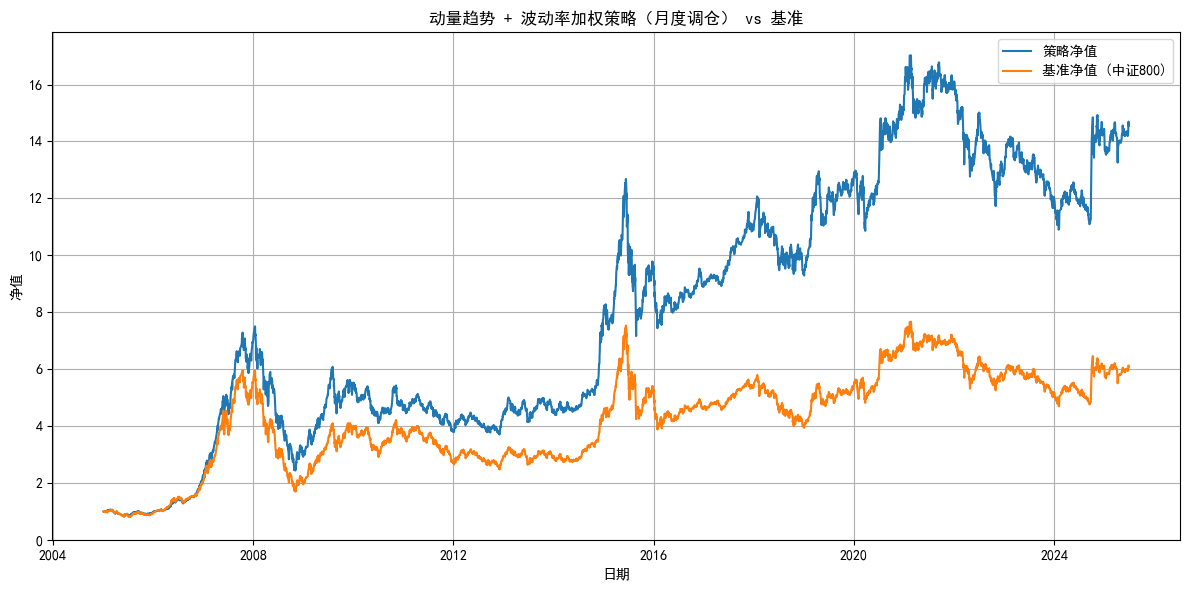

In [23]:
# 绘制净值曲线
plt.figure(figsize=(12,6))
plt.plot(best_portfolio_nav, label='策略净值')
plt.plot(benchmark_nav, label='基准净值 (中证800)')
plt.title('动量趋势 + 波动率加权策略（月度调仓） vs 基准')
plt.xlabel('日期')
plt.ylabel('净值')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

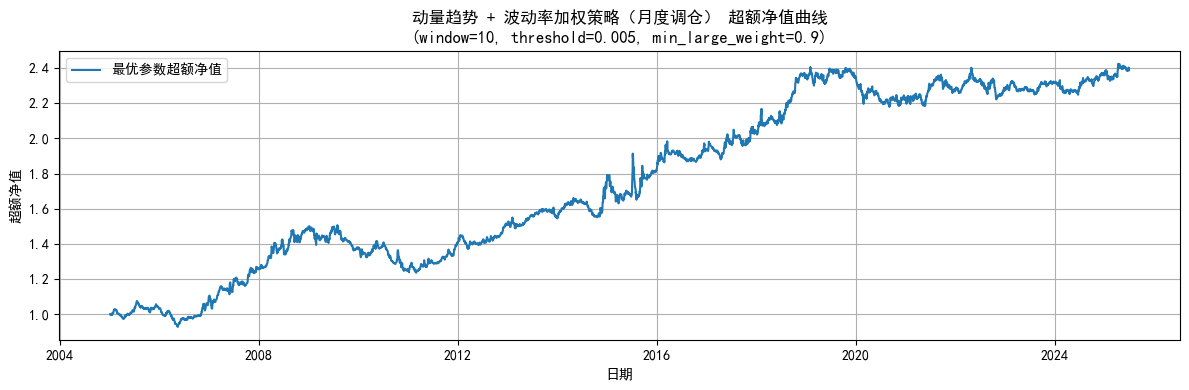

In [24]:
# 绘制超额净值曲线
# =============================
plt.figure(figsize=(12,4))
plt.plot(best_excess_nav, label='最优参数超额净值')
plt.title(f'动量趋势 + 波动率加权策略（月度调仓） 超额净值曲线\n(window={best_window}, threshold={best_threshold}, min_large_weight={best_min_large_weight})')
plt.xlabel('日期')
plt.ylabel('超额净值')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

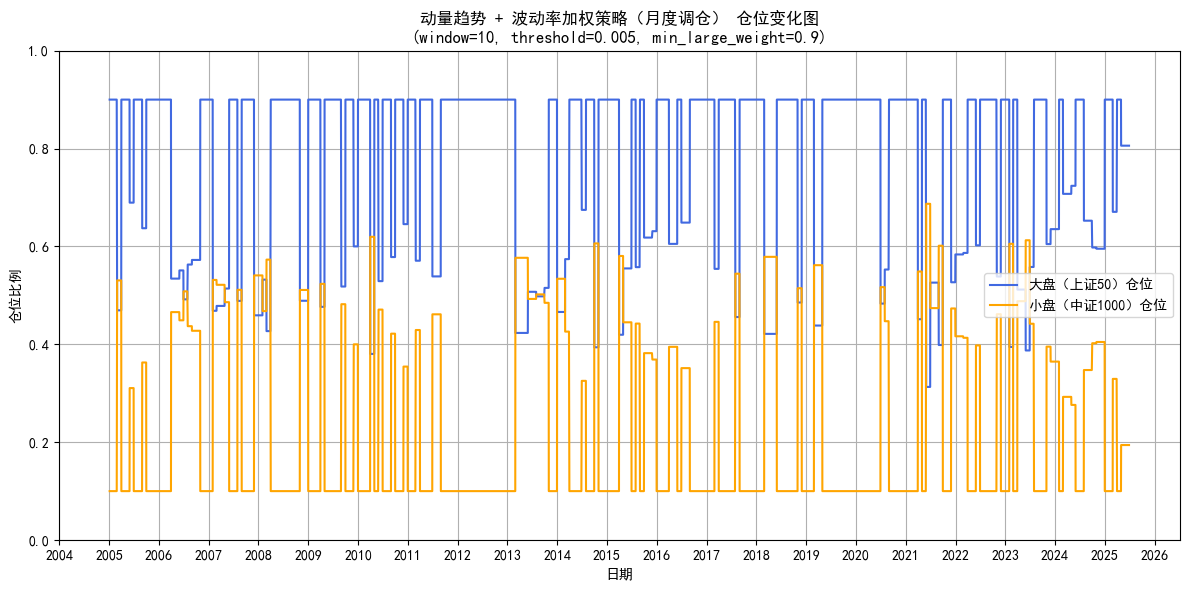

In [25]:
# 绘制仓位随时间变化图
# =============================
plt.figure(figsize=(12,6))
plt.plot(best_position_df.index, best_position_df['position_50'], label='大盘（上证50）仓位', color='royalblue')
plt.plot(best_position_df.index, best_position_df['position_1000'], label='小盘（中证1000）仓位', color='orange')
plt.title(f'动量趋势 + 波动率加权策略（月度调仓） 仓位变化图\n(window={best_window}, threshold={best_threshold}, min_large_weight={best_min_large_weight})')
plt.xlabel('日期')
plt.ylabel('仓位比例')
plt.ylim(0,1)
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()

## 动态配置

In [26]:
def dynamic_allocation_strategy(df, lookback_months=12):
    """
    动态调整大小盘配置策略

    参数:
    - df: DataFrame，index为交易日期，包含'50收益'和'中证1000全收益'收盘价列
    - lookback_months: int，回看月数（如12个月）

    返回:
    - position_df: DataFrame，包含 position_50（大盘） 和 position_1000（小盘）每日仓位
    """

    lookback_days = lookback_months * 21  # 约21交易日/每月
    weights = [(i/10, 1 - i/10) for i in range(11)]  # [(小盘，大盘)]

    returns_50 = df['50收益'].pct_change().fillna(0)
    returns_1000 = df['中证1000全收益'].pct_change().fillna(0)

    # 每月最后一个实际交易日
    month_end_dates = df.index.to_series().groupby(df.index.to_period('M')).idxmax()

    position_50 = pd.Series(index=df.index, dtype='float64')
    position_1000 = pd.Series(index=df.index, dtype='float64')

    for date in month_end_dates:
        date_loc = df.index.get_loc(date)
        lookback_start_loc = max(0, date_loc - lookback_days)

        window_returns_50 = returns_50.iloc[lookback_start_loc:date_loc+1]
        window_returns_1000 = returns_1000.iloc[lookback_start_loc:date_loc+1]

        # 计算每种配置的年化收益
        ann_returns = []
        for w_50, w_1000 in weights:
            portfolio_returns = w_50 * window_returns_1000 + w_1000 * window_returns_50
            portfolio_nav = (1 + portfolio_returns).cumprod()
            annual_return = portfolio_nav.iloc[-1] ** (252 / len(portfolio_nav)) - 1
            ann_returns.append(annual_return)

        # 选择最佳配置
        best_idx = np.argmax(ann_returns)
        best_w_50, best_w_1000 = weights[best_idx]

        # 记录当月配置
        position_50.loc[date] = best_w_1000  # 大盘
        position_1000.loc[date] = best_w_50  # 小盘

    # 前向填充每日持仓
    position_50 = position_50.ffill().fillna(0.5)
    position_1000 = position_1000.ffill().fillna(0.5)

    # 返回每日配置 DataFrame
    position_df = pd.DataFrame({
        'position_50': position_50,
        'position_1000': position_1000
    }, index=df.index)

    return position_df

In [27]:
# === 运行策略函数，获取每日配置 ===
position_df = dynamic_allocation_strategy(df, lookback_months=12)

# === 计算每日收益率 ===
returns_50 = df['50收益'].pct_change().fillna(0)
returns_1000 = df['中证1000全收益'].pct_change().fillna(0)

portfolio_returns = position_df['position_50'] * returns_50 + position_df['position_1000'] * returns_1000
portfolio_returns = portfolio_returns.fillna(0)

# === 计算净值曲线 ===
portfolio_nav = (1 + portfolio_returns).cumprod()
benchmark_nav = df['800收益'] / df['800收益'].iloc[0]
excess_nav = portfolio_nav / benchmark_nav

# === 计算回测指标 ===
annual_return = portfolio_nav.iloc[-1] ** (252 / len(portfolio_nav)) - 1
annual_vol = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = annual_return / annual_vol
max_drawdown = (portfolio_nav / portfolio_nav.cummax() - 1).min()
calmar_ratio = annual_return / abs(max_drawdown)

# === 输出回测指标 ===
print("【回测指标 - 动态配置策略】")
print(f"年化收益率：{annual_return:.2%}")
print(f"年化波动率：{annual_vol:.2%}")
print(f"夏普比率：{sharpe_ratio:.2f}")
print(f"最大回撤：{max_drawdown:.2%}")
print(f"Calmar Ratio：{calmar_ratio:.2f}")


【回测指标 - 动态配置策略】
年化收益率：8.60%
年化波动率：28.06%
夏普比率：0.31
最大回撤：-75.43%
Calmar Ratio：0.11


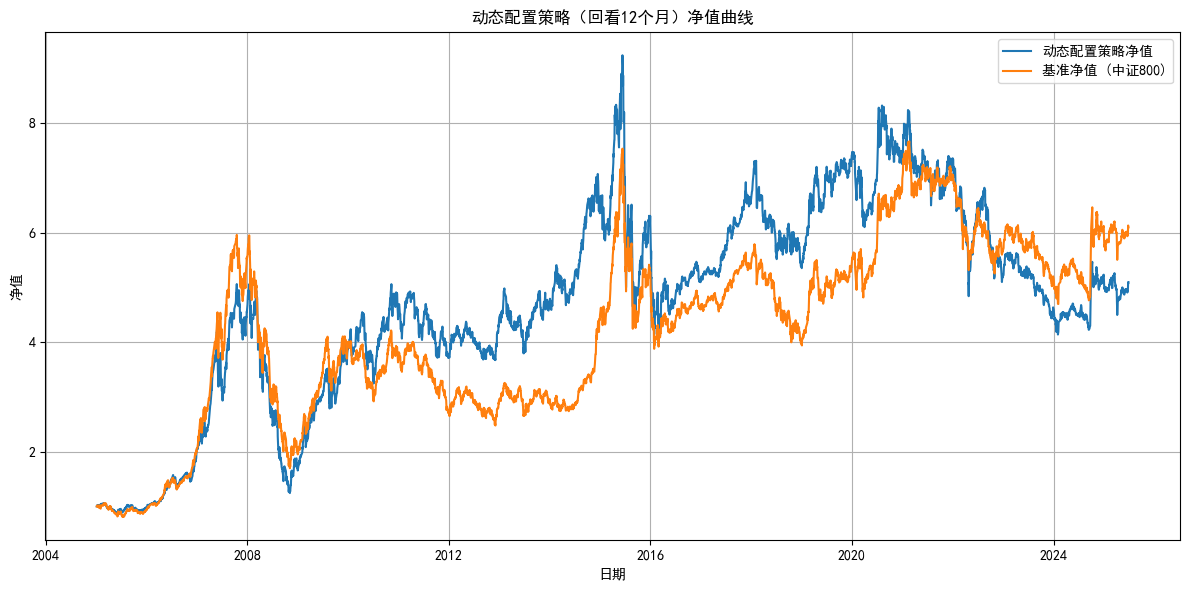

In [28]:
# === 绘制净值曲线 ===
plt.figure(figsize=(12,6))
plt.plot(portfolio_nav, label='动态配置策略净值')
plt.plot(benchmark_nav, label='基准净值 (中证800)')
plt.legend()
plt.grid(True)
plt.title('动态配置策略（回看12个月）净值曲线')
plt.xlabel('日期')
plt.ylabel('净值')
plt.tight_layout()
plt.show()

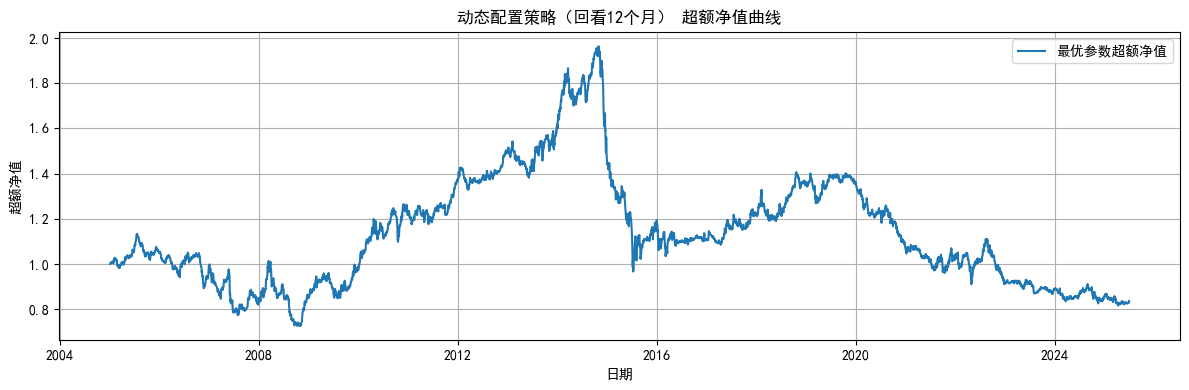

In [29]:
# 绘制超额净值曲线
# =============================
plt.figure(figsize=(12,4))
plt.plot(excess_nav, label='最优参数超额净值')
plt.title(f'动态配置策略（回看12个月） 超额净值曲线')
plt.xlabel('日期')
plt.ylabel('超额净值')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

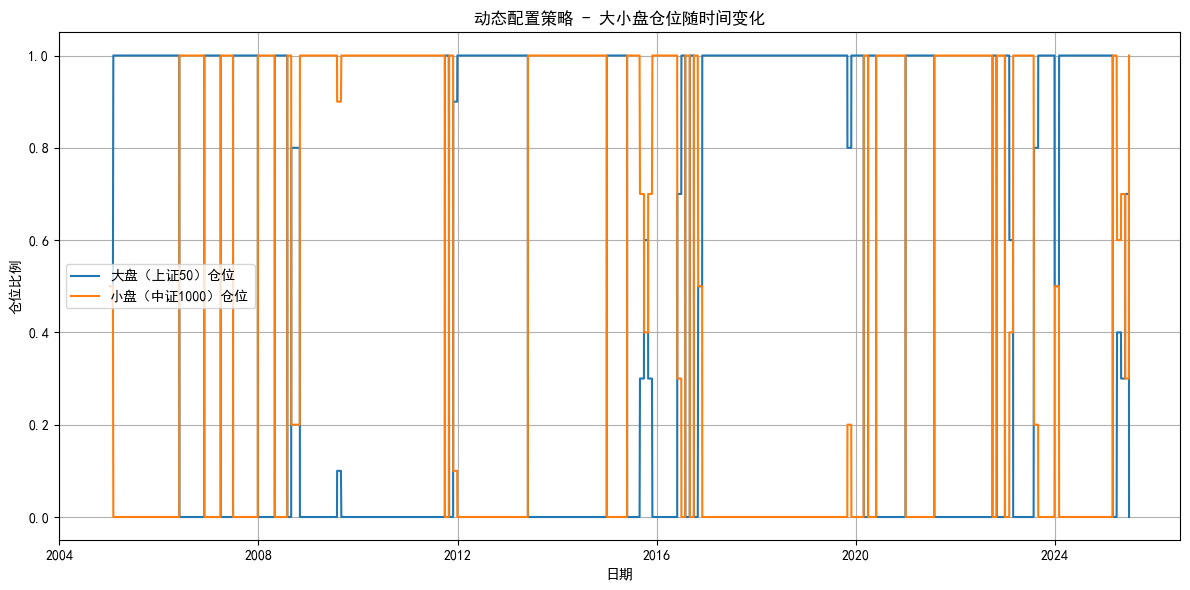

In [30]:
# === 绘制仓位变化图 ===
plt.figure(figsize=(12,6))
plt.plot(position_df.index, position_df['position_50'], label='大盘（上证50）仓位')
plt.plot(position_df.index, position_df['position_1000'], label='小盘（中证1000）仓位')
plt.title('动态配置策略 - 大小盘仓位随时间变化')
plt.xlabel('日期')
plt.ylabel('仓位比例')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 多因子策略

引入换手率

In [31]:
# === 1. 读取换手率 sheet ===
turnover_df = pd.read_excel(file_path, sheet_name='自由流通换手率')

# === 2. 检查数据结构 ===
print(turnover_df.head())
print(turnover_df.columns)

# 如果需要，将日期列转换为 datetime 格式，并设置 index
if 'date' in turnover_df.columns:
    turnover_df['date'] = pd.to_datetime(turnover_df['date'])
    turnover_df = turnover_df.set_index('date')

# === 3. 查看缺失值情况 ===
missing_ratio = turnover_df.isna().mean()
print("【缺失值占比】\n", missing_ratio)

  Unnamed: 0    50收益  中证1000全收益  800收益
0 2005-01-04  1.0537        NaN    NaN
1 2005-01-05  0.7895        NaN    NaN
2 2005-01-06  0.7197        NaN    NaN
3 2005-01-07  0.8014        NaN    NaN
4 2005-01-10  0.6480        NaN    NaN
Index(['Unnamed: 0', '50收益', '中证1000全收益', '800收益'], dtype='object')
【缺失值占比】
 Unnamed: 0    0.000000
50收益          0.000000
中证1000全收益     0.477081
800收益         0.098512
dtype: float64


中证1000缺失值非常多，这里统计一下缺失值分布情况

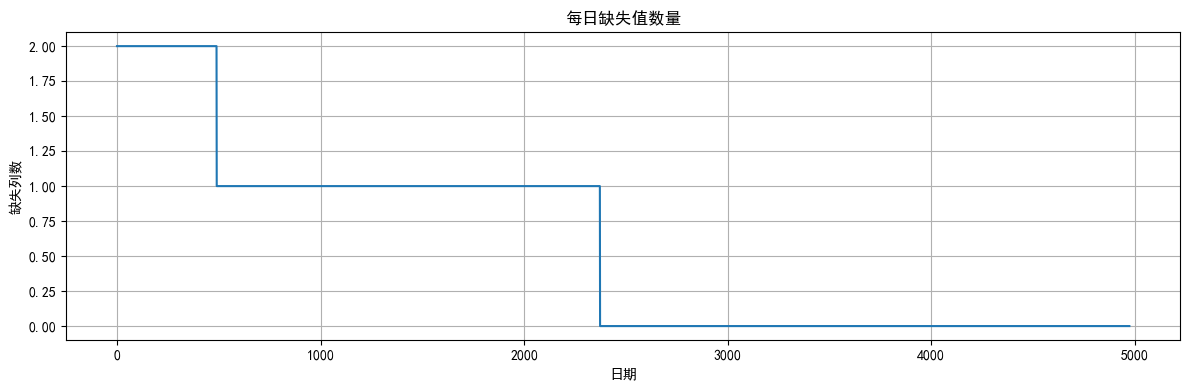

In [32]:
# 计算每日缺失情况
daily_missing = turnover_df.isna().sum(axis=1)

# 绘制每日缺失分布
plt.figure(figsize=(12,4))
plt.plot(daily_missing)
plt.title('每日缺失值数量')
plt.xlabel('日期')
plt.ylabel('缺失列数')
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
# 计算连续缺失天数（以中证1000全收益为例）
missing_1000 = turnover_df['中证1000全收益'].isna()

# 标记连续区段
missing_runs = missing_1000.ne(missing_1000.shift()).cumsum()
consecutive_missing = missing_1000.groupby(missing_runs).sum()
max_consecutive_missing = consecutive_missing.max()

print(f"【中证1000全收益】连续缺失天数最大值：{max_consecutive_missing}")

【中证1000全收益】连续缺失天数最大值：2373


In [34]:
# 找到中证1000全收益第一个非缺失值的位置
first_valid_index = turnover_df['中证1000全收益'].first_valid_index()

# 使用 .index.get_loc() 获取整数位置
first_valid_pos = turnover_df.index.get_loc(first_valid_index)

# 舍弃此前所有数据
turnover_df = turnover_df.iloc[first_valid_pos:]

# 如果后续需要同步修改df
df = df.iloc[first_valid_pos:]

# 检查结果
print(f"新数据起始日期：{first_valid_index}")
print(turnover_df.head())

新数据起始日期：2373
     Unnamed: 0    50收益  中证1000全收益   800收益
2373 2014-10-17  1.5440     4.4870  2.6613
2374 2014-10-20  1.0236     3.6939  1.9042
2375 2014-10-21  1.0840     3.7180  2.0020
2376 2014-10-22  1.0453     3.4351  1.8307
2377 2014-10-23  1.2128     3.4691  2.0562


In [35]:
# === 查看缺失值情况 ===
missing_ratio = turnover_df.isna().mean()
print("【缺失值占比】\n", missing_ratio)

【缺失值占比】
 Unnamed: 0    0.0
50收益          0.0
中证1000全收益     0.0
800收益         0.0
dtype: float64


In [36]:
df

,50收益,中证1000全收益,800收益,50_over_800,1000_over_800,50_MA20,50_MA60,1000_MA20,1000_MA60,50_RSI14,1000_RSI14
date,,,,,,,,,,,
2014-10-17,1997.6146,6315.2861,3289.8895,0.607198,1.919604,2003.290485,1985.039832,6280.003665,5792.895722,60.043243,68.775272
2014-10-20,2002.4413,6415.1984,3315.8855,0.603893,1.934686,2002.618100,1987.931793,6292.141035,5814.554328,57.349229,69.322250
2014-10-21,1988.0869,6361.5041,3286.6215,0.604903,1.935576,2002.664865,1990.562222,6312.238540,5835.534213,37.304290,59.630745
2014-10-22,1983.4690,6282.8092,3260.9517,0.608249,1.926680,2002.232495,1992.778467,6326.304700,5854.011600,38.683842,52.754402
2014-10-23,1970.3438,6181.6723,3225.3351,0.610896,1.916598,2000.836495,1994.552718,6332.930865,5872.004572,35.613007,44.424551
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-23,4455.3660,6956.7820,5861.0160,0.760170,1.186958,4439.289520,4410.557777,6969.316715,6888.502525,55.444797,52.357610
2025-06-24,4507.0519,7090.5930,5937.6386,0.759065,1.194177,4441.829530,4411.738837,6980.466860,6887.106537,64.970040,56.763144
2025-06-25,4567.4175,7185.6353,6030.3551,0.757404,1.191577,4448.555055,4414.326600,6997.456325,6886.837130,72.365727,59.027855


In [37]:
turnover_df

,Unnamed: 0,50收益,中证1000全收益,800收益
2373,2014-10-17,1.5440,4.4870,2.6613
2374,2014-10-20,1.0236,3.6939,1.9042
2375,2014-10-21,1.0840,3.7180,2.0020
2376,2014-10-22,1.0453,3.4351,1.8307
2377,2014-10-23,1.2128,3.4691,2.0562
...,...,...,...,...
4969,2025-06-23,1.0874,3.4800,1.4527
4970,2025-06-24,1.2408,4.1969,1.8096
4971,2025-06-25,1.2873,4.4488,2.2012
4972,2025-06-26,1.0930,4.5683,2.0496


In [38]:
# === 检查 index 类型一致 ===
print(df.index.dtype)
print(turnover_df.index.dtype)

datetime64[ns]
int64


In [39]:
# 如果 turnover_df 中日期列仍然存在，先将其转换为 datetime
turnover_df['Unnamed: 0'] = pd.to_datetime(turnover_df['Unnamed: 0'])

# 设置为 index
turnover_df = turnover_df.set_index('Unnamed: 0')

# 再检查 index 类型
print(df.index.dtype)
print(turnover_df.index.dtype)

# 找到 turnover_df 的起始日期
start_date = turnover_df.index.min()

# 将 df 截断为 start_date 之后
df_1 = df[df.index >= start_date]

# 再次 merge
merged_df = df_1.merge(turnover_df, left_index=True, right_index=True, how='left')

datetime64[ns]
datetime64[ns]


In [40]:
merged_df

,50收益_x,中证1000全收益_x,800收益_x,50_over_800,1000_over_800,50_MA20,50_MA60,1000_MA20,1000_MA60,50_RSI14,1000_RSI14,50收益_y,中证1000全收益_y,800收益_y
date,,,,,,,,,,,,,,
2014-10-17,1997.6146,6315.2861,3289.8895,0.607198,1.919604,2003.290485,1985.039832,6280.003665,5792.895722,60.043243,68.775272,1.5440,4.4870,2.6613
2014-10-20,2002.4413,6415.1984,3315.8855,0.603893,1.934686,2002.618100,1987.931793,6292.141035,5814.554328,57.349229,69.322250,1.0236,3.6939,1.9042
2014-10-21,1988.0869,6361.5041,3286.6215,0.604903,1.935576,2002.664865,1990.562222,6312.238540,5835.534213,37.304290,59.630745,1.0840,3.7180,2.0020
2014-10-22,1983.4690,6282.8092,3260.9517,0.608249,1.926680,2002.232495,1992.778467,6326.304700,5854.011600,38.683842,52.754402,1.0453,3.4351,1.8307
2014-10-23,1970.3438,6181.6723,3225.3351,0.610896,1.916598,2000.836495,1994.552718,6332.930865,5872.004572,35.613007,44.424551,1.2128,3.4691,2.0562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-23,4455.3660,6956.7820,5861.0160,0.760170,1.186958,4439.289520,4410.557777,6969.316715,6888.502525,55.444797,52.357610,1.0874,3.4800,1.4527
2025-06-24,4507.0519,7090.5930,5937.6386,0.759065,1.194177,4441.829530,4411.738837,6980.466860,6887.106537,64.970040,56.763144,1.2408,4.1969,1.8096
2025-06-25,4567.4175,7185.6353,6030.3551,0.757404,1.191577,4448.555055,4414.326600,6997.456325,6886.837130,72.365727,59.027855,1.2873,4.4488,2.2012


simple eda for exchange rate

In [41]:
# === 计算换手率与未来收益的相关性 ===
merged_df['future_return'] = merged_df['50收益_x'].pct_change().shift(-1)

corr_50 = merged_df['50收益_y'].corr(merged_df['future_return'])
corr_1000 = merged_df['中证1000全收益_y'].corr(merged_df['future_return'])

print(f"50换手率 与 次日收益 相关性: {corr_50:.4f}")
print(f"1000换手率 与 次日收益 相关性: {corr_1000:.4f}")

50换手率 与 次日收益 相关性: 0.0312
1000换手率 与 次日收益 相关性: -0.0113


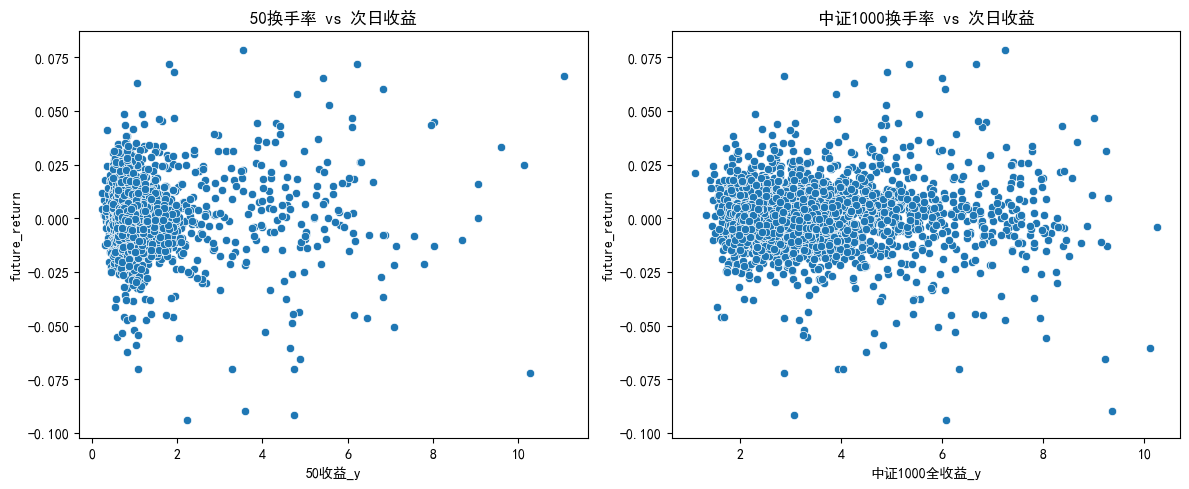

In [42]:
# === 绘制换手率与未来收益散点图 ===
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x=merged_df['50收益_y'], y=merged_df['future_return'])
plt.title('50换手率 vs 次日收益')

plt.subplot(1,2,2)
sns.scatterplot(x=merged_df['中证1000全收益_y'], y=merged_df['future_return'])
plt.title('中证1000换手率 vs 次日收益')

plt.tight_layout()
plt.show()

相关性较低,换手率暂时只作为过滤因子使用

In [43]:
def momentum_volatility_turnover_strategy(df, window=10, threshold=0.005, min_large_weight=0.9,
                                          turnover_low_q=0.1, turnover_high_q=0.95):
    """
    大小盘切换策略：动量趋势 + 波动率加权 + 换手率过滤

    参数:
    - df: DataFrame，包含 '50收益', '中证1000全收益', '50换手率', '1000换手率' 四列
    - window: int，计算动量与波动率的窗口期
    - threshold: float，小盘相对大盘收益率超过阈值才切换
    - min_large_weight: float，不满足动量条件时，大盘的最小配置比例
    - turnover_low_q: float，换手率低分位阈值
    - turnover_high_q: float，换手率高分位阈值

    返回:
    - position_df: DataFrame，包含 'position_50' 和 'position_1000' 两列，二者加总为1
    """

    # === 1. 计算window期收益率
    r_50 = df['50收益_x'].pct_change(periods=window)
    r_1000 = df['中证1000全收益_x'].pct_change(periods=window)

    # === 2. 计算window期波动率
    vol_50 = df['50收益_x'].pct_change().rolling(window).std()
    vol_1000 = df['中证1000全收益_x'].pct_change().rolling(window).std()

    # 避免除零错误
    epsilon = 1e-8
    inv_vol_50 = 1 / (vol_50 + epsilon)
    inv_vol_1000 = 1 / (vol_1000 + epsilon)
    total_inv_vol = inv_vol_50 + inv_vol_1000

    # === 3. 波动率加权
    weight_50 = inv_vol_50 / total_inv_vol
    weight_1000 = inv_vol_1000 / total_inv_vol

    # === 4. 动量条件
    momentum_condition = r_1000 > r_50 + threshold

    # === 5. 根据动量条件决定仓位配置
    position_50 = np.where(momentum_condition, weight_50, min_large_weight)
    position_1000 = np.where(momentum_condition, weight_1000, 1 - min_large_weight)

    # === 6. 换手率过滤逻辑
    # 计算换手率分位
    turnover_50_q_low = df['50收益_y'].quantile(turnover_low_q)
    turnover_50_q_high = df['50收益_y'].quantile(turnover_high_q)

    turnover_1000_q_low = df['中证1000全收益_y'].quantile(turnover_low_q)
    turnover_1000_q_high = df['中证1000全收益_y'].quantile(turnover_high_q)

    # 过滤：50换手率
    position_50 = np.where(df['50收益_y'] < turnover_50_q_low, 0, position_50)
    position_50 = np.where(df['50收益_y'] > turnover_50_q_high, position_50 * 0.5, position_50)

    # 过滤：1000换手率
    position_1000 = np.where(df['中证1000全收益_y'] < turnover_1000_q_low, 0, position_1000)
    position_1000 = np.where(df['中证1000全收益_y'] > turnover_1000_q_high, position_1000 * 0.5, position_1000)

    # === 7. 重新标准化（确保仓位和=1）
    position_sum = position_50 + position_1000
    # 防止分母为0，将零仓位日设置为各50%
    position_sum = np.where(position_sum == 0, 1, position_sum)
    position_50 /= position_sum
    position_1000 /= position_sum

    # === 8. 输出DataFrame
    position_df = pd.DataFrame({
        'position_50': position_50,
        'position_1000': position_1000
    }, index=df.index)

    return position_df

In [44]:
def momentum_volatility_turnover_strategy(df, window=10, threshold=0.005, min_large_weight=0.9,
                                          turnover_low_q=0.1, turnover_high_q=0.95):
    """
    大小盘切换策略：动量趋势 + 波动率加权 + 换手率过滤 + 每月调仓

    参数:
    - df: DataFrame，包含 '50收益_x'（收盘价）, '中证1000全收益_x', '50收益_y'（换手率）, '中证1000全收益_y'
    - window: int，计算动量与波动率的窗口期
    - threshold: float，小盘相对大盘收益率超过阈值才切换
    - min_large_weight: float，不满足动量条件时，大盘的最小配置比例
    - turnover_low_q: float，换手率低分位阈值
    - turnover_high_q: float，换手率高分位阈值

    返回:
    - position_df: DataFrame，包含 'position_50' 和 'position_1000' 两列，按月调仓
    """

    # 计算window期收益率
    r_50 = df['50收益_x'].pct_change(periods=window)
    r_1000 = df['中证1000全收益_x'].pct_change(periods=window)

    # 计算window期波动率
    vol_50 = df['50收益_x'].pct_change().rolling(window).std()
    vol_1000 = df['中证1000全收益_x'].pct_change().rolling(window).std()

    # 避免除零错误
    epsilon = 1e-8
    inv_vol_50 = 1 / (vol_50 + epsilon)
    inv_vol_1000 = 1 / (vol_1000 + epsilon)
    total_inv_vol = inv_vol_50 + inv_vol_1000

    # 波动率加权
    weight_50 = inv_vol_50 / total_inv_vol
    weight_1000 = inv_vol_1000 / total_inv_vol

    # 动量条件
    momentum_condition = r_1000 > r_50 + threshold

    # 根据动量条件决定仓位配置
    position_50 = np.where(momentum_condition, weight_50, min_large_weight)
    position_1000 = np.where(momentum_condition, weight_1000, 1 - min_large_weight)

    # 换手率过滤逻辑
    turnover_50_q_low = df['50收益_y'].quantile(turnover_low_q)
    turnover_50_q_high = df['50收益_y'].quantile(turnover_high_q)
    turnover_1000_q_low = df['中证1000全收益_y'].quantile(turnover_low_q)
    turnover_1000_q_high = df['中证1000全收益_y'].quantile(turnover_high_q)

    position_50 = np.where(df['50收益_y'] < turnover_50_q_low, 0, position_50)
    position_50 = np.where(df['50收益_y'] > turnover_50_q_high, position_50 * 0.5, position_50)
    position_1000 = np.where(df['中证1000全收益_y'] < turnover_1000_q_low, 0, position_1000)
    position_1000 = np.where(df['中证1000全收益_y'] > turnover_1000_q_high, position_1000 * 0.5, position_1000)

    # 重新标准化（确保仓位和=1）
    position_sum = position_50 + position_1000
    position_sum = np.where(position_sum == 0, 1, position_sum)  # 避免除零
    position_50 /= position_sum
    position_1000 /= position_sum

    # 构建DataFrame进行存贮
    position_df = pd.DataFrame({
        'position_50': position_50,
        'position_1000': position_1000
    }, index=df.index)

   
    position_df_monthly = position_df.resample('M').last()
    position_df = position_df_monthly.reindex(df.index, method='ffill')

    return position_df


In [45]:
# 回测
# 获取仓位
position_df = momentum_volatility_turnover_strategy(merged_df)

# 计算日收益率
returns_50 = merged_df['50收益_x'].pct_change()
returns_1000 = merged_df['中证1000全收益_x'].pct_change()

# 计算组合收益
portfolio_returns = position_df['position_50'] * returns_50 + position_df['position_1000'] * returns_1000
portfolio_returns = portfolio_returns.fillna(0)

# 计算净值曲线
portfolio_nav = (1 + portfolio_returns).cumprod()

# 计算基准（例如800收益）
benchmark_nav = merged_df['800收益_x'] / merged_df['800收益_x'].iloc[0]
excess_nav = portfolio_nav / benchmark_nav

# 输出回测指标
annual_return = portfolio_nav.iloc[-1] ** (252 / len(portfolio_nav)) - 1
annual_vol = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = annual_return / annual_vol
max_drawdown = (portfolio_nav / portfolio_nav.cummax() - 1).min()
calmar_ratio = annual_return / abs(max_drawdown)

print("【回测指标 - 多因子策略】")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")

【回测指标 - 多因子策略】
年化收益率: 11.50%
年化波动率: 21.73%
夏普比率: 0.53
最大回撤: -43.99%
Calmar Ratio: 0.26


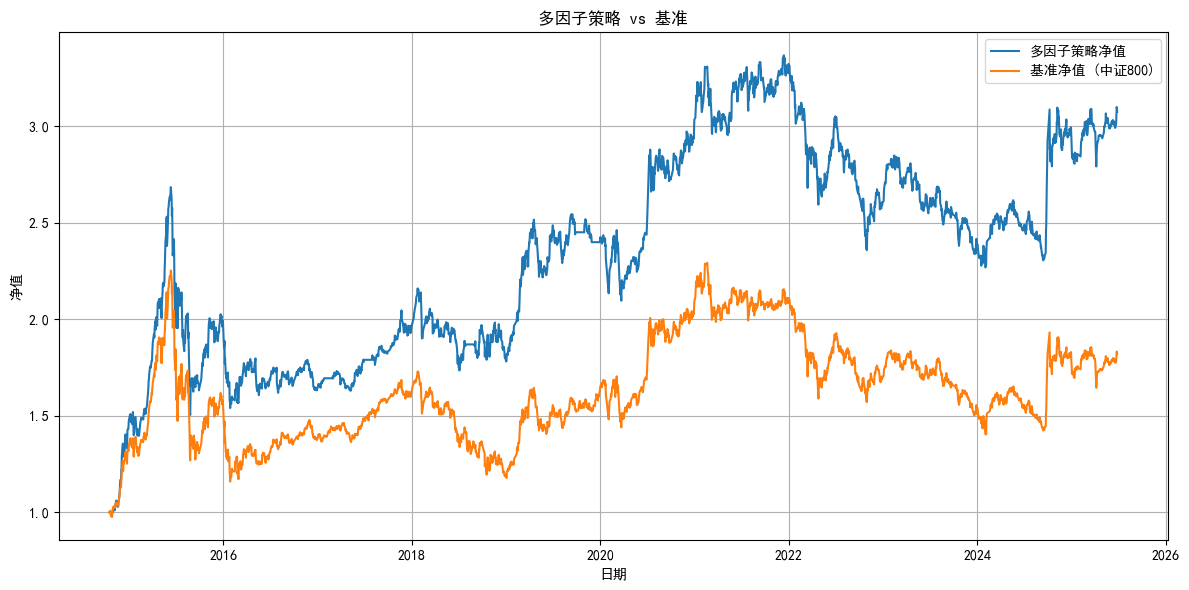

In [46]:
# 绘制净值曲线
plt.figure(figsize=(12,6))
plt.plot(portfolio_nav, label='多因子策略净值')
plt.plot(benchmark_nav, label='基准净值 (中证800)')
plt.title('多因子策略 vs 基准')
plt.xlabel('日期')
plt.ylabel('净值')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

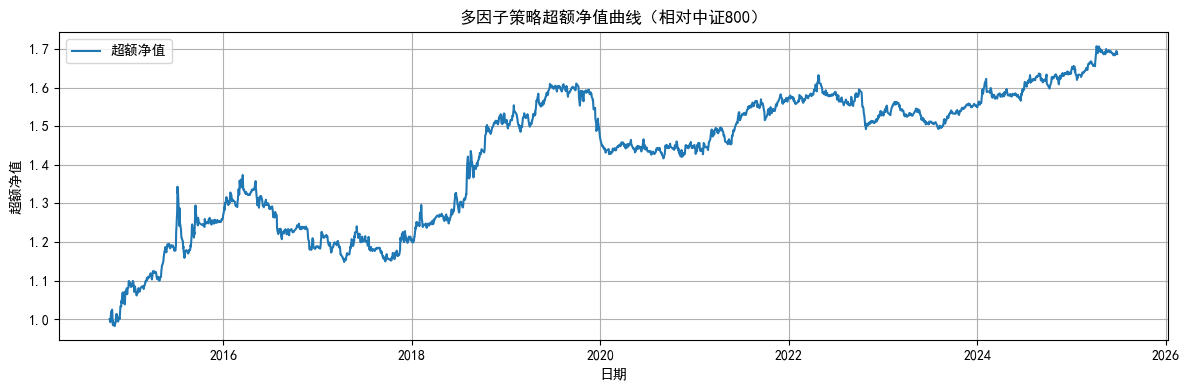

In [47]:
# 绘制超额净值
plt.figure(figsize=(12,4))
plt.plot(excess_nav, label='超额净值')
plt.title('多因子策略超额净值曲线（相对中证800）')
plt.xlabel('日期')
plt.ylabel('超额净值')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

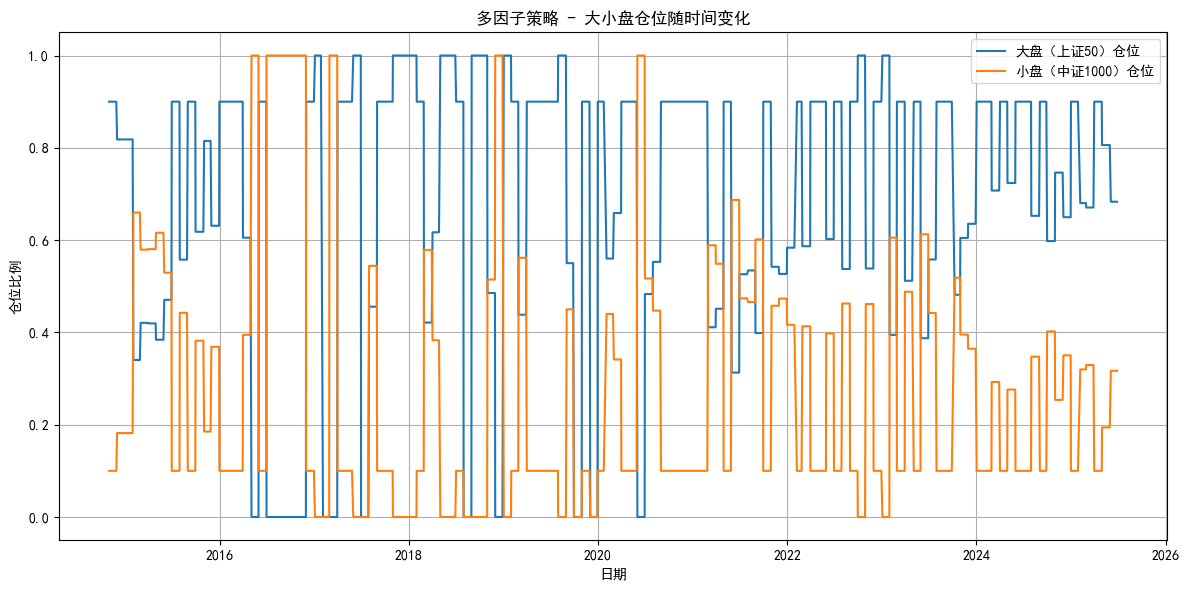

In [48]:
# 绘制仓位随时间变化
plt.figure(figsize=(12,6))
plt.plot(position_df.index, position_df['position_50'], label='大盘（上证50）仓位')
plt.plot(position_df.index, position_df['position_1000'], label='小盘（中证1000）仓位')
plt.title('多因子策略 - 大小盘仓位随时间变化')
plt.xlabel('日期')
plt.ylabel('仓位比例')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

参数搜索

In [49]:
# 定义回测函数（与超参数搜索公用） ===
def backtest(df, position_df, rebalance_freq='ME'):
    """
    回测函数：计算年化收益、波动率、最大回撤、Calmar Ratio
    """
    # 1. 调仓频率
    position_df_monthly = position_df.resample(rebalance_freq).last().ffill()

    # 2. 计算组合收益
    returns_50 = df['50收益_x'].pct_change()
    returns_1000 = df['中证1000全收益_x'].pct_change()
    portfolio_returns = (position_df_monthly['position_50'] * returns_50 +
                         position_df_monthly['position_1000'] * returns_1000).fillna(0)

    # 3. 计算净值
    portfolio_nav = (1 + portfolio_returns).cumprod()

    # 4. 计算指标（月度数据用12）
    annual_return = portfolio_nav.iloc[-1] ** (12 / len(portfolio_nav)) - 1
    annual_vol = portfolio_returns.std() * np.sqrt(12)
    max_drawdown = (portfolio_nav / portfolio_nav.cummax() - 1).min()
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

    return annual_return, annual_vol, max_drawdown, calmar_ratio


# === 超参数搜索范围 ===
windows = [5, 10, 15, 20, 30, 40, 50]
thresholds = np.arange(0.003, 0.02, 0.002)
min_large_weights = [0.7, 0.8, 0.9, 0.95]
low_qs = [0.01, 0.05, 0.1, 0.2]
high_qs = [0.8, 0.85, 0.9, 0.95, 0.98]

best_calmar = -np.inf
best_params = None

# === 超参数网格搜索 ===
for window, threshold, min_large_weight, low_q, high_q in itertools.product(
        windows, thresholds, min_large_weights, low_qs, high_qs):
    
    if high_q <= low_q:
        continue

    # 策略计算
    position_df = momentum_volatility_turnover_strategy(
        merged_df,
        window=window,
        threshold=threshold,
        min_large_weight=min_large_weight,
        turnover_low_q=low_q,
        turnover_high_q=high_q
    )

    # 回测
    ann_ret, ann_vol, max_dd, calmar = backtest(merged_df, position_df)

    # 更新最优
    if calmar > best_calmar:
        best_calmar = calmar
        best_params = (window, threshold, min_large_weight, low_q, high_q)
        print(f"New Best Calmar: {calmar:.3f}, Annual Return: {ann_ret:.2%}, Max DD: {max_dd:.2%}, Params: {best_params}")

# === 输出最终结果 ===
print("==== 最佳参数 ====")
print(f"Calmar: {best_calmar:.3f}, Params: {best_params}")

New Best Calmar: 0.024, Annual Return: 0.11%, Max DD: -4.48%, Params: (5, 0.003, 0.7, 0.01, 0.8)
New Best Calmar: 0.026, Annual Return: 0.11%, Max DD: -4.23%, Params: (5, 0.003, 0.7, 0.01, 0.85)
New Best Calmar: 0.027, Annual Return: 0.11%, Max DD: -4.23%, Params: (5, 0.003, 0.7, 0.05, 0.85)
New Best Calmar: 0.029, Annual Return: 0.12%, Max DD: -4.21%, Params: (5, 0.003, 0.8, 0.01, 0.8)
New Best Calmar: 0.030, Annual Return: 0.12%, Max DD: -4.03%, Params: (5, 0.003, 0.8, 0.01, 0.85)
New Best Calmar: 0.031, Annual Return: 0.13%, Max DD: -4.03%, Params: (5, 0.003, 0.8, 0.05, 0.85)
New Best Calmar: 0.034, Annual Return: 0.14%, Max DD: -3.94%, Params: (5, 0.003, 0.9, 0.01, 0.8)
New Best Calmar: 0.035, Annual Return: 0.13%, Max DD: -3.85%, Params: (5, 0.003, 0.9, 0.01, 0.85)
New Best Calmar: 0.035, Annual Return: 0.14%, Max DD: -3.94%, Params: (5, 0.003, 0.9, 0.05, 0.8)
New Best Calmar: 0.036, Annual Return: 0.14%, Max DD: -3.85%, Params: (5, 0.003, 0.9, 0.05, 0.85)
New Best Calmar: 0.037, 

In [50]:
best_window = 10
best_threshold = 0.0133
best_min_large_weight = 0.95
best_turnover_low_q = 0.05
best_turnover_high_q = 0.85

# 使用最优参数运行策略
position_df_best = momentum_volatility_turnover_strategy(
    merged_df,
    window=best_window,
    threshold=best_threshold,
    min_large_weight=best_min_large_weight,
    turnover_low_q=best_turnover_low_q,
    turnover_high_q=best_turnover_high_q
)

# 每月调仓
position_df_best_monthly = position_df_best.resample('ME').last().ffill()

# 计算月度收益率
returns_50 = merged_df['50收益_x'].pct_change().resample('ME').sum()
returns_1000 = merged_df['中证1000全收益_x'].pct_change().resample('ME').sum()

# 组合收益率
portfolio_returns = (position_df_best_monthly['position_50'] * returns_50 +
                     position_df_best_monthly['position_1000'] * returns_1000).fillna(0)

# 净值
portfolio_nav = (1 + portfolio_returns).cumprod()

# 基准
benchmark_nav = merged_df['800收益_x'].resample('ME').last()
benchmark_nav = benchmark_nav / benchmark_nav.iloc[0]
excess_nav = portfolio_nav / benchmark_nav

# === 输出回测指标
annual_return = portfolio_nav.iloc[-1] ** (12 / len(portfolio_nav)) - 1
annual_vol = portfolio_returns.std() * np.sqrt(12)
sharpe_ratio = annual_return / annual_vol
max_drawdown = (portfolio_nav / portfolio_nav.cummax() - 1).min()
calmar_ratio = annual_return / abs(max_drawdown)

print("【回测指标 - 多因子策略（最优参数）】")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")


【回测指标 - 多因子策略（最优参数）】
年化收益率: 16.00%
年化波动率: 22.09%
夏普比率: 0.72
最大回撤: -33.79%
Calmar Ratio: 0.47


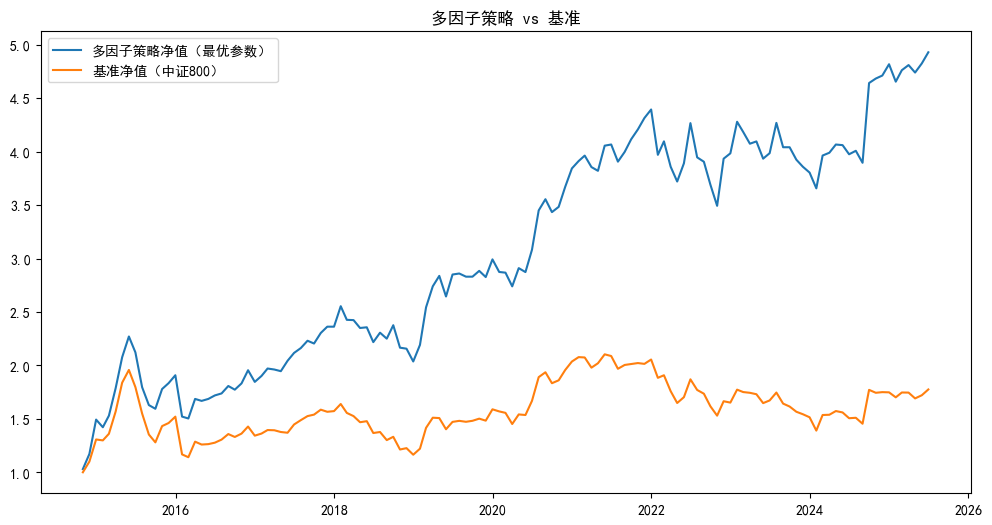

In [51]:
plt.figure(figsize=(12,6))
plt.plot(portfolio_nav, label='多因子策略净值（最优参数）')
plt.plot(benchmark_nav, label='基准净值（中证800）')
plt.title('多因子策略 vs 基准')
plt.legend()
plt.show()


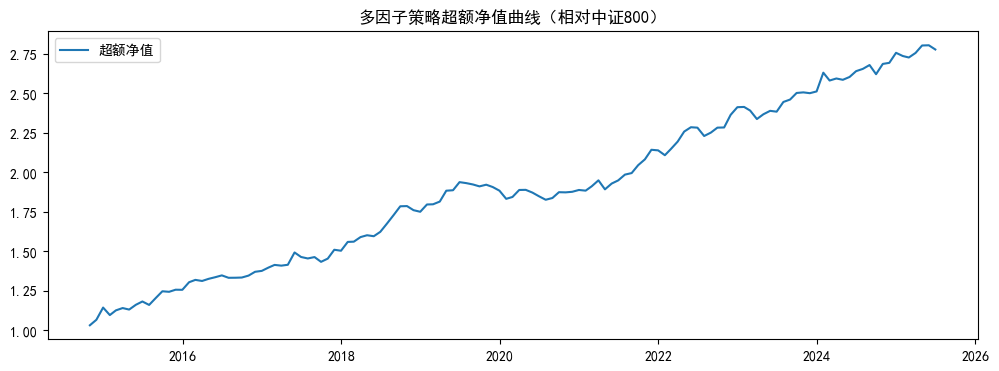

In [52]:
plt.figure(figsize=(12,4))
plt.plot(excess_nav, label='超额净值')
plt.title('多因子策略超额净值曲线（相对中证800）')
plt.legend()
plt.show()

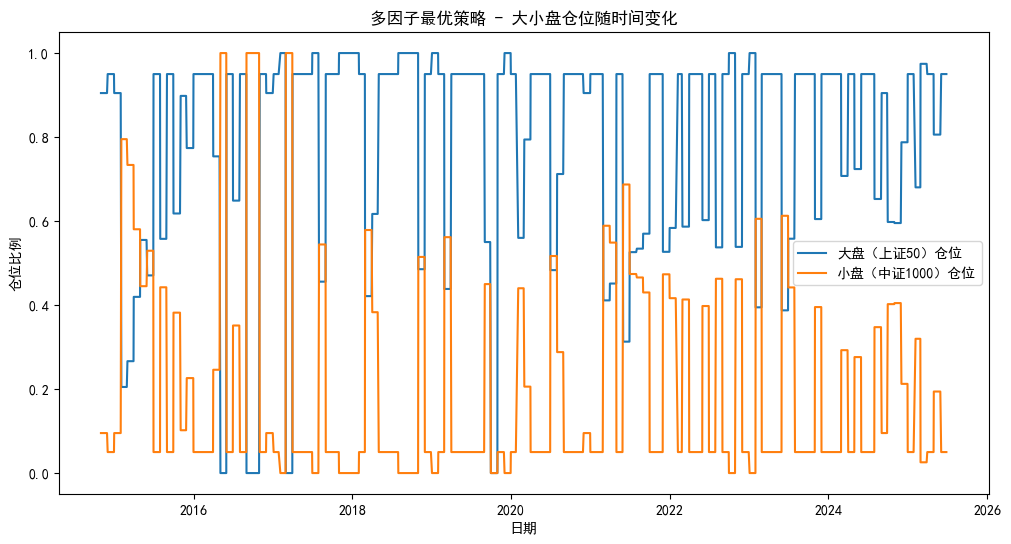

In [53]:
# === 仓位变化可视化 ===
plt.figure(figsize=(12, 6))
plt.plot(position_df_best.index, position_df_best['position_50'], label='大盘（上证50）仓位')
plt.plot(position_df_best.index, position_df_best['position_1000'], label='小盘（中证1000）仓位')
plt.legend()
plt.title('多因子最优策略 - 大小盘仓位随时间变化')
plt.ylabel('仓位比例')
plt.xlabel('日期')
plt.show()